## CNN

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import random
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from albumentations.pytorch import ToTensorV2
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast, Rotate, Resize

from ultralytics import YOLO
import math

from PIL import Image, ImageDraw, ImageFont

In [3]:
train_input_path = 'data/Train'

## Augumentation of the Image

In [4]:
def get_augmentation_pipeline():
    return Compose([
        HorizontalFlip(p=0.5),
        Rotate(0.1),
    ])


In [9]:
def balance_classes_with_augmentation(input_path, output_path, transform, target_count, csv_output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    data_for_csv = []

    for folder in os.listdir(input_path):
        print(f"Started processing '{folder}'")
        folder_path = os.path.join(input_path, folder)

        images = os.listdir(folder_path)
        current_count = len(images)

        if target_count <= current_count:
            # Randomly pick images up to the target count
            selected_images = random.sample(images, target_count)
        else:
            # Use all images and augment additional images
            selected_images = images.copy()
            augmentation_needed = target_count - current_count

        for image_file in selected_images:
            image_path = os.path.join(folder_path, image_file)
            save_path = os.path.join(output_path, image_file)
            
            # Simply copy the image from the source to the destination without processing
            shutil.copy(image_path, save_path)
            data_for_csv.append({
                "ClassId": folder,
                "Path": os.path.relpath(save_path, start=output_path)
            })

        if target_count > current_count:
            # Augment additional images
            for i in range(augmentation_needed):
                image_file = random.choice(images)  # Randomly pick an image to augment
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                augmented = transform(image=image)
                augmented_image = augmented['image']
                augmented_file_name = f"aug_{current_count + i}_{image_file}"
                save_path = os.path.join(output_path, augmented_file_name)
                cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                data_for_csv.append({
                    "ClassId": folder,
                    "Path": os.path.relpath(save_path, start=output_path)
                })

        print(f"Completed processing '{folder}'")

    df = pd.DataFrame(data_for_csv)
    df.to_csv(csv_output_path, index=False)

Clearing out the previous records information

In [8]:
csv_output_path = 'CSV Files/aug_train.csv'
with open(csv_output_path, 'w') as file:
    pass

In [50]:
train_output_path = 'Augmented_Train'
target_count = 500  # Target number of images per class
csv_output_path = 'CSV Files/aug_train.csv'

Augumetunig the Images and Saving them into new Folder

In [10]:
balance_classes_with_augmentation(train_input_path, train_output_path, get_augmentation_pipeline(), target_count, csv_output_path)

Started processing '0'
Completed processing '0'
Started processing '1'
Completed processing '1'
Started processing '10'
Completed processing '10'
Started processing '11'
Completed processing '11'
Started processing '12'
Completed processing '12'
Started processing '13'
Completed processing '13'
Started processing '14'
Completed processing '14'
Started processing '15'
Completed processing '15'
Started processing '16'
Completed processing '16'
Started processing '17'
Completed processing '17'
Started processing '18'
Completed processing '18'
Started processing '19'
Completed processing '19'
Started processing '2'
Completed processing '2'
Started processing '20'
Completed processing '20'
Started processing '21'
Completed processing '21'
Started processing '22'
Completed processing '22'
Started processing '23'
Completed processing '23'
Started processing '24'
Completed processing '24'
Started processing '25'
Completed processing '25'
Started processing '26'
Completed processing '26'
Starte

## Reading labels and Image Path from CSV

In [51]:
data = pd.read_csv(csv_output_path)

# Create a dictionary of ClassId and their counts
class_counts = data['ClassId'].value_counts().to_dict()

# Print the dictionary
print(class_counts)

{0: 500, 38: 500, 30: 500, 31: 500, 32: 500, 33: 500, 34: 500, 35: 500, 36: 500, 37: 500, 39: 500, 29: 500, 4: 500, 40: 500, 41: 500, 42: 500, 5: 500, 6: 500, 7: 500, 8: 500, 3: 500, 28: 500, 1: 500, 18: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 19: 500, 27: 500, 2: 500, 20: 500, 21: 500, 22: 500, 23: 500, 24: 500, 25: 500, 26: 500, 9: 500}


## Splitting The data into Training and Validation

In [14]:
# Load the CSV file into a DataFrame
df = pd.read_csv('CSV Files/aug_train.csv')

# Prepend the directory path to the image filenames
base_dir = 'Augmented_Train/'
df['Path'] = base_dir + df['Path']

# Ensure ClassId is a string (necessary if using categorical class_mode)
df['ClassId'] = df['ClassId'].astype(str)

# Split the data into training and validation sets (20% for validation)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Setup ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

# Function to adjust learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)




Found 17200 validated image filenames belonging to 43 classes.
Found 4300 validated image filenames belonging to 43 classes.


## Modile Compile and Summary

In [15]:
# Model architecture
inputs = tf.keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(43, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',      # Change the file extension to .keras
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# Train the model with learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler), early_stopping, model_checkpoint]
)

print(model.summary())

I0000 00:00:1734461149.427621    2884 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/ujwal/anaconda3/envs/cis568/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1734461158.395678   16586 service.cc:148] XLA service 0x7f5678014ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734461158.396335   16586 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-17 13:45:58.545867: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734461159.018060   16586 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-17 13:46:00.575774: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2213', 240 bytes spill stores, 240 bytes spill loads

2024-12-17 13:46:00.711650: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22

104/538 ━━━━━━━━━━━━━━━━━━━━ 4:17 594ms/step - accuracy: 0.1139 - loss: 4.1213

2024-12-17 13:47:12.273691: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2213', 64 bytes spill stores, 64 bytes spill loads

2024-12-17 13:47:12.494844: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2215', 488 bytes spill stores, 488 bytes spill loads



538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.3237 - loss: 2.7861
Epoch 1: val_loss improved from inf to 3.84493, saving model to best_model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 405s 722ms/step - accuracy: 0.3241 - loss: 2.7842 - val_accuracy: 0.1679 - val_loss: 3.8449 - learning_rate: 0.0010
Epoch 2/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.8330 - loss: 0.5501
Epoch 2: val_loss improved from 3.84493 to 2.42890, saving model to best_model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 395s 735ms/step - accuracy: 0.8330 - loss: 0.5500 - val_accuracy: 0.3288 - val_loss: 2.4289 - learning_rate: 0.0010
Epoch 3/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9071 - loss: 0.2981
Epoch 3: val_loss did not improve from 2.42890
538/538 ━━━━━━━━━━━━━━━━━━━━ 215s 398ms/step - accuracy: 0.9071 - loss: 0.2980 - val_accuracy: 0.3626 - val_loss: 2.9630 - learning_rate: 0.0010
Epoch 4/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9324 - loss: 0.2235
Epoch 4: va

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,994,627 (95.35 MB)

 Trainable params: 8,331,051 (31.78 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 16,662,104 (63.56 MB)

None


## Plotting the Accuracyt and Loss of the Model

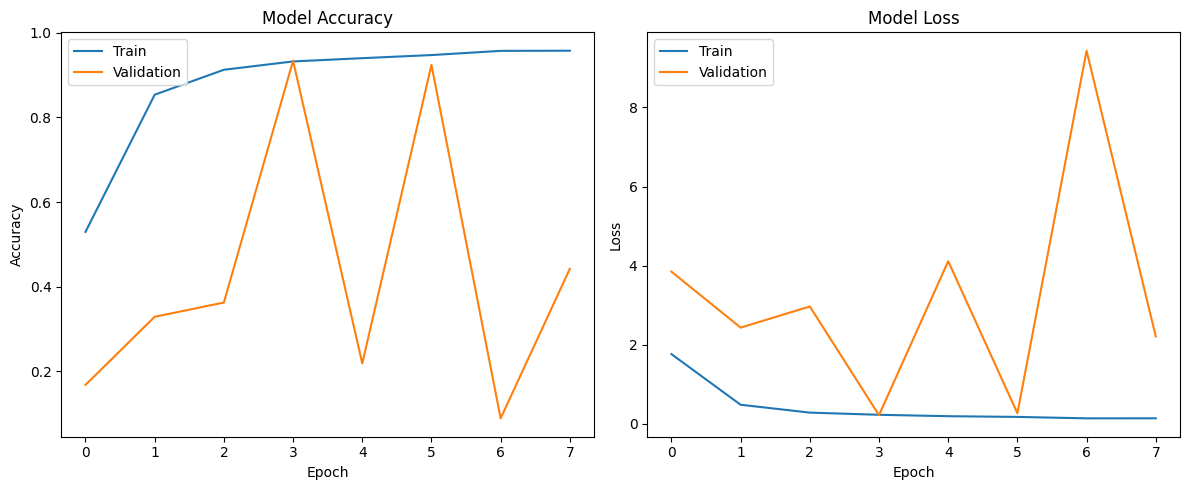

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Testing on the single image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
Predicted class for image: Vehicles over 3.5 metric tons prohibited


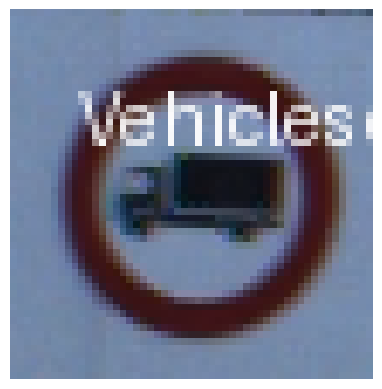

In [52]:
# Load the model
model = load_model('best_model.keras')

# Load and preprocess the image
image_path = 'data/Test/00000.png'
image = load_img(image_path, target_size=(180, 180))
image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

# Make prediction
predictions = model.predict(image_array)
predicted_index = np.argmax(predictions, axis=1)[0]

# Load the training class mapping (if not loaded, recreate from the training phase)
# Assuming 'aug_train.csv' was used to map ClassId to indices during training
df = pd.read_csv('CSV Files/aug_train.csv')
unique_class_ids = df['ClassId'].astype(str).unique()
class_mapping = {index: class_id for index, class_id in enumerate(unique_class_ids)}

predicted_class_id = class_mapping[predicted_index]  # Get the actual ClassId

# Load labels from CSV for the signage
labels_df = pd.read_csv('CSV Files/label_names.csv')
predicted_class_row = labels_df[labels_df['ClassId'] == int(predicted_class_id)]

if not predicted_class_row.empty:
    predicted_class_name = predicted_class_row['SignName'].values[0]
    print(f"Predicted class for image: {predicted_class_name}")
else:
    print("ClassId not found in the labels file.")

image_display = Image.open(image_path)
draw = ImageDraw.Draw(image_display)
font = ImageFont.load_default()
text = f"{predicted_class_name}"
draw.text((10, 10), text, font=font, fill=(255, 255, 255))

# Display the image
plt.imshow(image_display)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Testing on the whole Model

In [22]:
test_df = pd.read_csv('CSV Files/Test.csv')

test_df['ClassId'] = test_df['ClassId'].astype(str)

In [23]:
# Load the model
model = load_model('best_model.keras')

# Preprocessing function assuming you normalized images by dividing by 255 during training
def preprocess_image(img):
    img = img / 255.0
    return img

# Setup the data generator for the test set
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Create a generator for the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='data',
    x_col='Path',
    y_col='ClassId',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for maintaining label order
)

# Predict classes
preds = model.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)

# Retrieve true class indices
true_class_indices = test_generator.classes

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_class_indices, predicted_class_indices)
print(f"Test accuracy: {accuracy:.4f}")


Found 12630 validated image filenames belonging to 43 classes.


/home/ujwal/anaconda3/envs/cis568/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 158s 398ms/step
Test accuracy: 0.8420


## Yolo

## Splitting the Dta training and Validation

In [4]:
def validation_Data(input_path1):
    if not os.path.exists(input_path1):
        raise ValueError(f'{input_path1} Path not exists...!')
    
    val_path = './data/val'
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    
    for folder in os.listdir(input_path1):
        folder_path = os.path.join(input_path1, folder)
        save_folder = os.path.join(val_path, folder)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        
        images = os.listdir(folder_path)
        current_count = len(images)
        print(f'{folder_path} count {current_count}')
        
        # select 10 % of images as validation images
        num_Select = math.ceil((10.0 / 100) * current_count)
        
        num_to_select = max(1, num_Select)
        
        val_images = random.sample(images, num_to_select)
        
        print(f'val path {save_folder} count {len(images)}')
        
        for img in val_images:
            src_path = os.path.join(folder_path, img)
            dest_path = os.path.join(save_folder, img)
            
            
            # Handle filename conflicts
            if os.path.exists(dest_path):
                base, ext = os.path.splitext(img)
                counter = 1
                while os.path.exists(dest_path):
                    new_name = f"{base}_{counter}{ext}"
                    dest_path = os.path.join(save_folder, new_name)
                    counter += 1

            shutil.move(src_path, dest_path)
            
        
        print(f'Images on {folder_path} after val dataset is {len(os.listdir(folder_path))} ...!')

In [56]:
input_path1 = 'data/Train' 
validation_Data(input_path1)

data/Train/0 count 210
val path ./data/val/0 count 210
Images on data/Train/0 after val dataset is 189 ...!
data/Train/1 count 2220
val path ./data/val/1 count 2220
Images on data/Train/1 after val dataset is 1998 ...!
data/Train/10 count 2010
val path ./data/val/10 count 2010
Images on data/Train/10 after val dataset is 1809 ...!
data/Train/11 count 1320
val path ./data/val/11 count 1320
Images on data/Train/11 after val dataset is 1188 ...!
data/Train/12 count 2100
val path ./data/val/12 count 2100
Images on data/Train/12 after val dataset is 1890 ...!
data/Train/13 count 2160
val path ./data/val/13 count 2160
Images on data/Train/13 after val dataset is 1944 ...!
data/Train/14 count 780
val path ./data/val/14 count 780
Images on data/Train/14 after val dataset is 702 ...!
data/Train/15 count 630
val path ./data/val/15 count 630
Images on data/Train/15 after val dataset is 567 ...!
data/Train/16 count 420
val path ./data/val/16 count 420
Images on data/Train/16 after val dataset is 3

## Compiling and Training the Model

In [6]:
model = YOLO('yolo11n-cls.pt')

#train the model
results = model.train(data='./data', epochs=20, imgsz=640, patience=4,
                      batch=16, save=True, project='yolov11-gtsb', name='initial_run')

New https://pypi.org/project/ultralytics/8.3.51 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=./data, epochs=20, time=None, patience=4, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov11-gtsb, name=initial_run, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

train: Scanning /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/train... 35288 images, 0 corrupt: 100%|██████████| 35288/35288 [01:05<00:00, 535.10it/s]


train: New cache created: /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/train.cache


val: Scanning /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/val... 3921 images, 0 corrupt: 100%|██████████| 3921/3921 [00:08<00:00, 477.69it/s]


val: New cache created: /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov11-gtsb/initial_run
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.25it/s]

                   all      0.816       0.97



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.11it/s]

                   all      0.908      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:10<00:00, 12.20it/s]

                   all      0.942      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.37it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.23it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 12.55it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 13.39it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 13.02it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:12<00:00,  9.59it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      1.81G     0.1122          8        640: 100%|██████████| 2206/2206 [02:45<00:00, 13.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.45it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20      1.91G    0.09127          8        640: 100%|██████████| 2206/2206 [02:34<00:00, 14.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 12.91it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20      1.81G    0.08756          8        640: 100%|██████████| 2206/2206 [02:38<00:00, 13.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:10<00:00, 11.89it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20      1.81G    0.08416          8        640: 100%|██████████| 2206/2206 [02:57<00:00, 12.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 12.44it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      1.81G    0.07699          8        640: 100%|██████████| 2206/2206 [02:38<00:00, 13.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 13.05it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20      1.81G    0.06594          8        640: 100%|██████████| 2206/2206 [02:32<00:00, 14.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.39it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20      1.81G    0.06514          8        640: 100%|██████████| 2206/2206 [02:40<00:00, 13.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:14<00:00,  8.45it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      1.81G    0.05809          8        640: 100%|██████████| 2206/2206 [02:49<00:00, 12.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.22it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      1.81G    0.05269          8        640: 100%|██████████| 2206/2206 [02:32<00:00, 14.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 13.02it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      1.81G    0.04772          8        640: 100%|██████████| 2206/2206 [02:37<00:00, 14.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 12.45it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      1.81G    0.04217          8        640: 100%|██████████| 2206/2206 [02:52<00:00, 12.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:09<00:00, 12.33it/s]

                   all      0.999          1



20 epochs completed in 1.023 hours.
Optimizer stripped from yolov11-gtsb/initial_run/weights/last.pt, 3.3MB
Optimizer stripped from yolov11-gtsb/initial_run/weights/best.pt, 3.3MB

Validating yolov11-gtsb/initial_run/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 112 layers, 1,581,107 parameters, 0 gradients, 3.2 GFLOPs
train: /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/train... found 35288 images in 43 classes ✅ 
val: /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/val... found 3921 images in 43 classes ✅ 
test: /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/test... found 12630 images in 1 classes: ERROR ❌️ requires 43 classes, not 1


               classes   top1_acc   top5_acc: 100%|██████████| 123/123 [00:13<00:00,  9.44it/s]


                   all      0.999          1
Speed: 0.5ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to yolov11-gtsb/initial_run


## Testing Single Image

In [10]:
model = YOLO('yolov11-gtsb/initial_run/weights/best.pt')

labels_df = pd.read_csv('CSV Files/label_names.csv')  # Make sure the path is correct
class_id_to_name = labels_df.set_index('ClassId')['SignName'].to_dict()

# Load and resize the image
image_path = 'data/test/00500.png'
image = cv2.imread(image_path)

# Resize the image while preserving aspect ratio
resized_image = cv2.resize(image, (640, 640), interpolation=cv2.INTER_LINEAR)

# Feed the resized image to the model (adjust according to your model's input requirements)
result = model(resized_image)  # Make sure the model can accept direct numpy array input
# Output only the class name of the detected object
if result[0].probs:
    top_class_id = result[0].probs.top1  # Directly use the 'top1' attribute which holds the index
    class_name = result[0].names[top_class_id]
    sign_name = class_id_to_name.get(int(class_name), 'Unknown')  # Get the sign name from the dictionary

    # Draw the sign name on the image
    cv2.putText(resized_image, f"Detected Class: {sign_name}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Show the image
    cv2.imshow('Detection', resized_image)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.destroyAllWindows()
else:
    print("No object detected.")


0: 640x640 22 1.00, 25 0.00, 23 0.00, 19 0.00, 9 0.00, 13.5ms
Speed: 12.9ms preprocess, 13.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


## Testing on whole Test Dataset

In [12]:
model = YOLO('yolov11-gtsb/initial_run/weights/best.pt')

# Path to the test CSV and test folder
test_csv_path = 'CSV Files/Test.csv'  # Update with your test CSV path
test_folder_path = 'data'       # Update with your test folder path

# Read the test CSV
test_df = pd.read_csv(test_csv_path)  # Assumes columns: 'image_path', 'class_id'

# Initialize counters
correct_predictions = 0
total_predictions = 0

# Iterate over each row in the test DataFrame
for index, row in test_df.iterrows():
    image_path = os.path.join(test_folder_path, row['Path'])  # Full image path
    ground_truth_class_id = row['ClassId']  # Ground truth class ID
    
    # Run prediction
    results = model(image_path)
    
    # Extract the top class ID
    if results[0].probs is not None:
        probs = results[0].probs
        top_class_id = probs.top1  # Class ID with the highest probability
        predicted_class_name = results[0].names[int(top_class_id)]  # Get class name
        
        # Compare predicted class with ground truth (account for mapping issues if needed)
        if int(predicted_class_name) == int(ground_truth_class_id):
            correct_predictions += 1
        
        total_predictions += 1

# Calculate accuracy
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")


image 1/1 /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/Test/00000.png: 640x640 16 1.00, 30 0.00, 42 0.00, 10 0.00, 7 0.00, 17.0ms
Speed: 17.5ms preprocess, 17.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/Test/00001.png: 640x640 1 1.00, 0 0.00, 5 0.00, 28 0.00, 7 0.00, 13.0ms
Speed: 14.7ms preprocess, 13.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/Test/00002.png: 640x640 38 1.00, 39 0.00, 32 0.00, 40 0.00, 41 0.00, 12.9ms
Speed: 13.3ms preprocess, 12.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/nellu/Documents/ece5831-2024-final-project/project/data/Test/00003.png: 640x640 33 0.83, 34 0.16, 40 0.00, 35 0.00, 37 0.00, 13.2ms
Speed: 13.9ms preprocess, 13.2ms inference, 0.3ms postprocess per image at shape (1, 3,

## Testing on the Live Video

In [15]:
# Load the YOLO model
model = YOLO('yolov11-gtsb/initial_run/weights/best.pt')

# Path to the video file
video_path = 'live_video/live_video.mp4'


# Start capturing video from the file
cap = cv2.VideoCapture(video_path)

# Load the CSV file with class ID and sign name mappings
labels_df = pd.read_csv('CSV Files/label_names.csv')
class_id_to_name = labels_df.set_index('ClassId')['SignName'].to_dict()

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break  # Breaks the loop if no frames are left or there's an error

    # Resize the frame to the required size for the model
    resized_frame = cv2.resize(frame, (640, 640), interpolation=cv2.INTER_LINEAR)

    # Feed the resized image to the model
    result = model(resized_frame)

    # Check if any object is detected and display the class name
    if result[0].probs:
        top_class_id = result[0].probs.top1  # Directly use the 'top1' attribute which holds the index
        class_name = result[0].names[top_class_id]
        sign_name = class_id_to_name.get(int(class_name), 'Unknown')  # Get the sign name from the dictionary
        # Draw the sign name on the frame
        cv2.putText(frame, sign_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Display the resulting frame
    cv2.imshow('YOLO Object Detection', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture and destroy all windows
cap.release()
cv2.destroyAllWindows()


0: 640x640 11 0.48, 12 0.17, 13 0.16, 5 0.04, 38 0.04, 34.5ms
Speed: 21.8ms preprocess, 34.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 0.47, 12 0.17, 13 0.15, 5 0.04, 26 0.04, 29.2ms
Speed: 33.9ms preprocess, 29.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 0.34, 12 0.33, 13 0.09, 38 0.06, 5 0.04, 32.9ms
Speed: 19.6ms preprocess, 32.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 0.35, 11 0.33, 13 0.09, 38 0.06, 5 0.04, 32.0ms
Speed: 32.2ms preprocess, 32.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 0.38, 12 0.31, 13 0.08, 38 0.07, 5 0.05, 33.4ms
Speed: 18.3ms preprocess, 33.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 0.35, 12 0.33, 13 0.08, 38 0.06, 5 0.05, 26.2ms
Speed: 18.5ms preprocess, 26.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 0.36, 12 0.33, 13 0